# CSE 572: Lab 6

In this lab, you will practice implementing feed-forward network and parameter tuning with k-fold cross valivation.

To execute and make changes to this notebook, click File > Save a copy to save your own version in your Google Drive or Github. Read the step-by-step instructions below carefully. To execute the code, click on each cell below and press the SHIFT-ENTER keys simultaneously or by clicking the Play button.

When you finish executing all code/exercises, save your notebook then download a copy (.ipynb file). Submit the following **three** things:
1. a link to your Colab notebook,
2. the .ipynb file, and
3. a pdf of the executed notebook on Canvas.

To generate a pdf of the notebook, check the instructions on Canvas.

# **PUT YOUR GROUP INFO HERE**

| Group number |         Group 30 |            |
|--------------|------------------|------------|
| Member 1     |Animesh Chaudhary | 1229421130 |
| Member 2     |                  |            |
| Member 3     |                  |            |
| Member 4     |                  |            |

In [30]:
# Import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

# Set the random seed for reproducibility
seed = 0
tf.random.set_seed(seed)

## Feed-forward neural networks

### Load the dataset

For this example, we will use the [Cleveland Heart Disease dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease). Review the dataset documentation to learn more about the attributes and other aspects of the dataset. The dataset consists of a CSV file with 303 rows. Each row contains information about a patient. There are 14 attribute columns and one binary class column (`target`) that reports whether or not a patient had a heart disease. We will train a feed-forward neural network model to predict whether or not a given patient has a heart disease based on the attribute values.

In [31]:
# Load the dataset
data = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/heart.csv")

In [32]:
# Print sample rows
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [33]:
# Print the number of rows and columns
data.shape

(303, 14)

Split the dataset into three randomly-sampled subsets: training (60%), validation (20%), and test (20%). Use the `seed` variable for the `random_state`.

In [34]:
train, val, test = np.split(data.sample(frac=1, random_state=seed), [int(.6*len(data)), int(.8*len(data))])

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Print the number of samples in each of the three subsets and the number of instances from each class. For example, for the training set you might print "The training set has __ instances (__ heart disease, __ no disease)".

In [35]:
# YOUR CODE HERE
def print_dataset_info(name, dataset):
    total = len(dataset)
    heart_disease = dataset['target'].sum()  # Count of '1' in target column
    no_disease = total - heart_disease       # Count of '0' in target column
    print(f"The {name} set has {total} instances ({heart_disease} heart disease, {no_disease} no disease)")


print_dataset_info("Training", train)
print_dataset_info("Validation", val)
print_dataset_info("Test", test)


The Training set has 181 instances (48 heart disease, 133 no disease)
The Validation set has 61 instances (18 heart disease, 43 no disease)
The Test set has 61 instances (17 heart disease, 44 no disease)


### Prepare the dataset

Before we can feed this dataset to our model for training and evaluation, we need to perform a few steps to get it ready:
1. Convert the dataframes to Dataset objects
2. Normalize the numerical feature values
3. Binarize the Categorical features by converting to one-hot encodings

In [36]:
# Convert dataframes to Dataset objects
def dataframe_to_dataset(df, shuffle=True):
    df = df.copy()
    # Remove the target column and store in a separate array
    labels = df.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
      ds = ds.shuffle(buffer_size=len(df), reshuffle_each_iteration=False)

    return ds


train_ds_original = dataframe_to_dataset(train)
val_ds_original = dataframe_to_dataset(val)
test_ds_original = dataframe_to_dataset(test)

The Dataset object yields a tuple containing the input feature vector and target (class value): `(input, target)`. `input` is a dictionary of features and `target` is the value 0 or 1. The code below prints an example instance drawn from the training Dataset object.

In [37]:
for x, y in train_ds_original.take(1):
    print("Input:", x)
    print("\nTarget:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=63>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=135>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=252>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=172>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'normal'>}

Target: tf.Tensor(0, shape=(), dtype=int64)


We can use the batch() function in keras to create batches from the full dataset for passing to the model. For the training dataset, we'll define a hyperparameter `batch_size` that we will set. For the validation and test sets, we will make the batch size equivalent to the size of the subset so all samples in that subset are evaluated each time the dataset is evaluated by the model.

In [38]:
batch_size = 32
train_ds = train_ds_original.batch(batch_size)
val_ds = val_ds_original.batch(val.shape[0])
test_ds = test_ds_original.batch(test.shape[0])

There are seven categorical features in the dataset: `sex`, `cp`, `fbs`, `restecg`, `exang`, `ca`, and `thal`. You can read more about what these features mean in the [dataset documentation](https://archive.ics.uci.edu/ml/datasets/heart+Disease). All of them except `thal` have integer data type while `thal` has String data type. Below we define a function to encode these feature values as one-hot encodings using the [IntegerLookup()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/IntegerLookup) and [StringLookup()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) layers. These layers create look-up tables for mapping a set of arbitrary integers or strings to a one-hot encoding. We use an `is_string` argument to indicate whether we should use the `StringLookup()` for `thal` or the `IntegerLookup()` for the remaining features.

In [39]:
def encode_categorical_feature(feature, name, dataset, is_string):
    from tensorflow.keras.layers import IntegerLookup
    from tensorflow.keras.layers import StringLookup

    # Create lookup layer to turn categorical features into 1-hot integer encodings
    if is_string:
        lookup = StringLookup(output_mode="binary")
    else:
        lookup = IntegerLookup(output_mode="binary")

    # Prepare a Dataset that only yields the feature of interest
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Find the set of possible values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

The remaining features in the dataset (`age`, `trestbps`, `chol`, `thalach`, `oldpeak`, and `slope`) are all numerical measurements. You can read more about what these features mean in the [dataset documentation](https://archive.ics.uci.edu/ml/datasets/heart+Disease). We don't need to encode the numerical features, but we do want to scale them to the same range of values (e.g., using standardization or normalization). Below we define a function that uses the [Normalization()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization) layer to standardize the data (subtract the mean and divide by the standard deviation for each feature).

In [40]:
def normalize(feature, name, dataset):
    from tensorflow.keras.layers import Normalization

    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields the feature of interest
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    norm_feature = normalizer(feature)
    return norm_feature

Now we can apply these functions to each of our features and return an encoded/preprocessed input layer. We first create tensor variables for each of the inputs, then apply the appropriate function, then concatenate all of these input layers for each feature together to form a single input feature layer.

In [41]:
all_inputs = [
    keras.Input(shape=(1,), name="sex", dtype="int64"),
    keras.Input(shape=(1,), name="cp", dtype="int64"),
    keras.Input(shape=(1,), name="fbs", dtype="int64"),
    keras.Input(shape=(1,), name="restecg", dtype="int64"),
    keras.Input(shape=(1,), name="exang", dtype="int64"),
    keras.Input(shape=(1,), name="ca", dtype="int64"),
    keras.Input(shape=(1,), name="thal", dtype="string"),
    keras.Input(shape=(1,), name="age"),
    keras.Input(shape=(1,), name="trestbps"),
    keras.Input(shape=(1,), name="chol"),
    keras.Input(shape=(1,), name="thalach"),
    keras.Input(shape=(1,), name="oldpeak"),
    keras.Input(shape=(1,), name="slope"),
]

In [42]:
feature_layer = layers.concatenate(
    [
        encode_categorical_feature(all_inputs[0], "sex", train_ds, False),
        encode_categorical_feature(all_inputs[1], "cp", train_ds, False),
        encode_categorical_feature(all_inputs[2], "fbs", train_ds, False),
        encode_categorical_feature(all_inputs[3], "restecg", train_ds, False),
        encode_categorical_feature(all_inputs[4], "exang", train_ds, False),
        encode_categorical_feature(all_inputs[5], "ca", train_ds, False),
        encode_categorical_feature(all_inputs[6], "thal", train_ds, True),
        normalize(all_inputs[7], "age", train_ds),
        normalize(all_inputs[8], "trestbps", train_ds),
        normalize(all_inputs[9], "chol", train_ds),
        normalize(all_inputs[10], "thalach", train_ds),
        normalize(all_inputs[11], "oldpeak", train_ds),
        normalize(all_inputs[12], "slope", train_ds)
    ]
)

### Build the model

Now that we've prepared our dataset, we can construct our neural network model. We construct the model by composing Layer objects starting with the input layer (which we've already defined as `feature_layer`) and ending with the output layer (which will be the final output of the model). In this example, we will only use [Dense()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers which are simple fully-connected feed-forward layers (i.e., each output from layer `i-1` is connected by a weight variable to every neuron in layer `i`). We will create a network with only one hidden layer (between the input and output layers).

The Dense() layer object allows us to specify the activation function to use using the `activation` argument. In class, we talked about several activation functions including sigmoid, sign, and tanh. Another commonly used activation function is the rectified linear unit, or "ReLU" function. Another commonly used activation function is the rectified linear unit, or "ReLU" function, which has the equation $a(z)=max(0,z)$. We will use `relu` as our activation function in this example for all layers except the final layer, which will use a `sigmoid` activation.

In [43]:
# Create a variable for the number of units/neurons in the layer
h1_units = 32
# Create a Dense layer and append it to the input layer
h1_layer = layers.Dense(h1_units, activation='relu')(feature_layer)

# Create an output layer with one output representing the likelihood of
# heart disease and append it to the hidden layer
output_layer = layers.Dense(1, activation="sigmoid")(h1_layer)

# Build the model specifying the input and output layer
model = keras.Model(inputs=all_inputs, outputs=output_layer)

We can plot our completed model to visualize the input, hidden, and output layers.

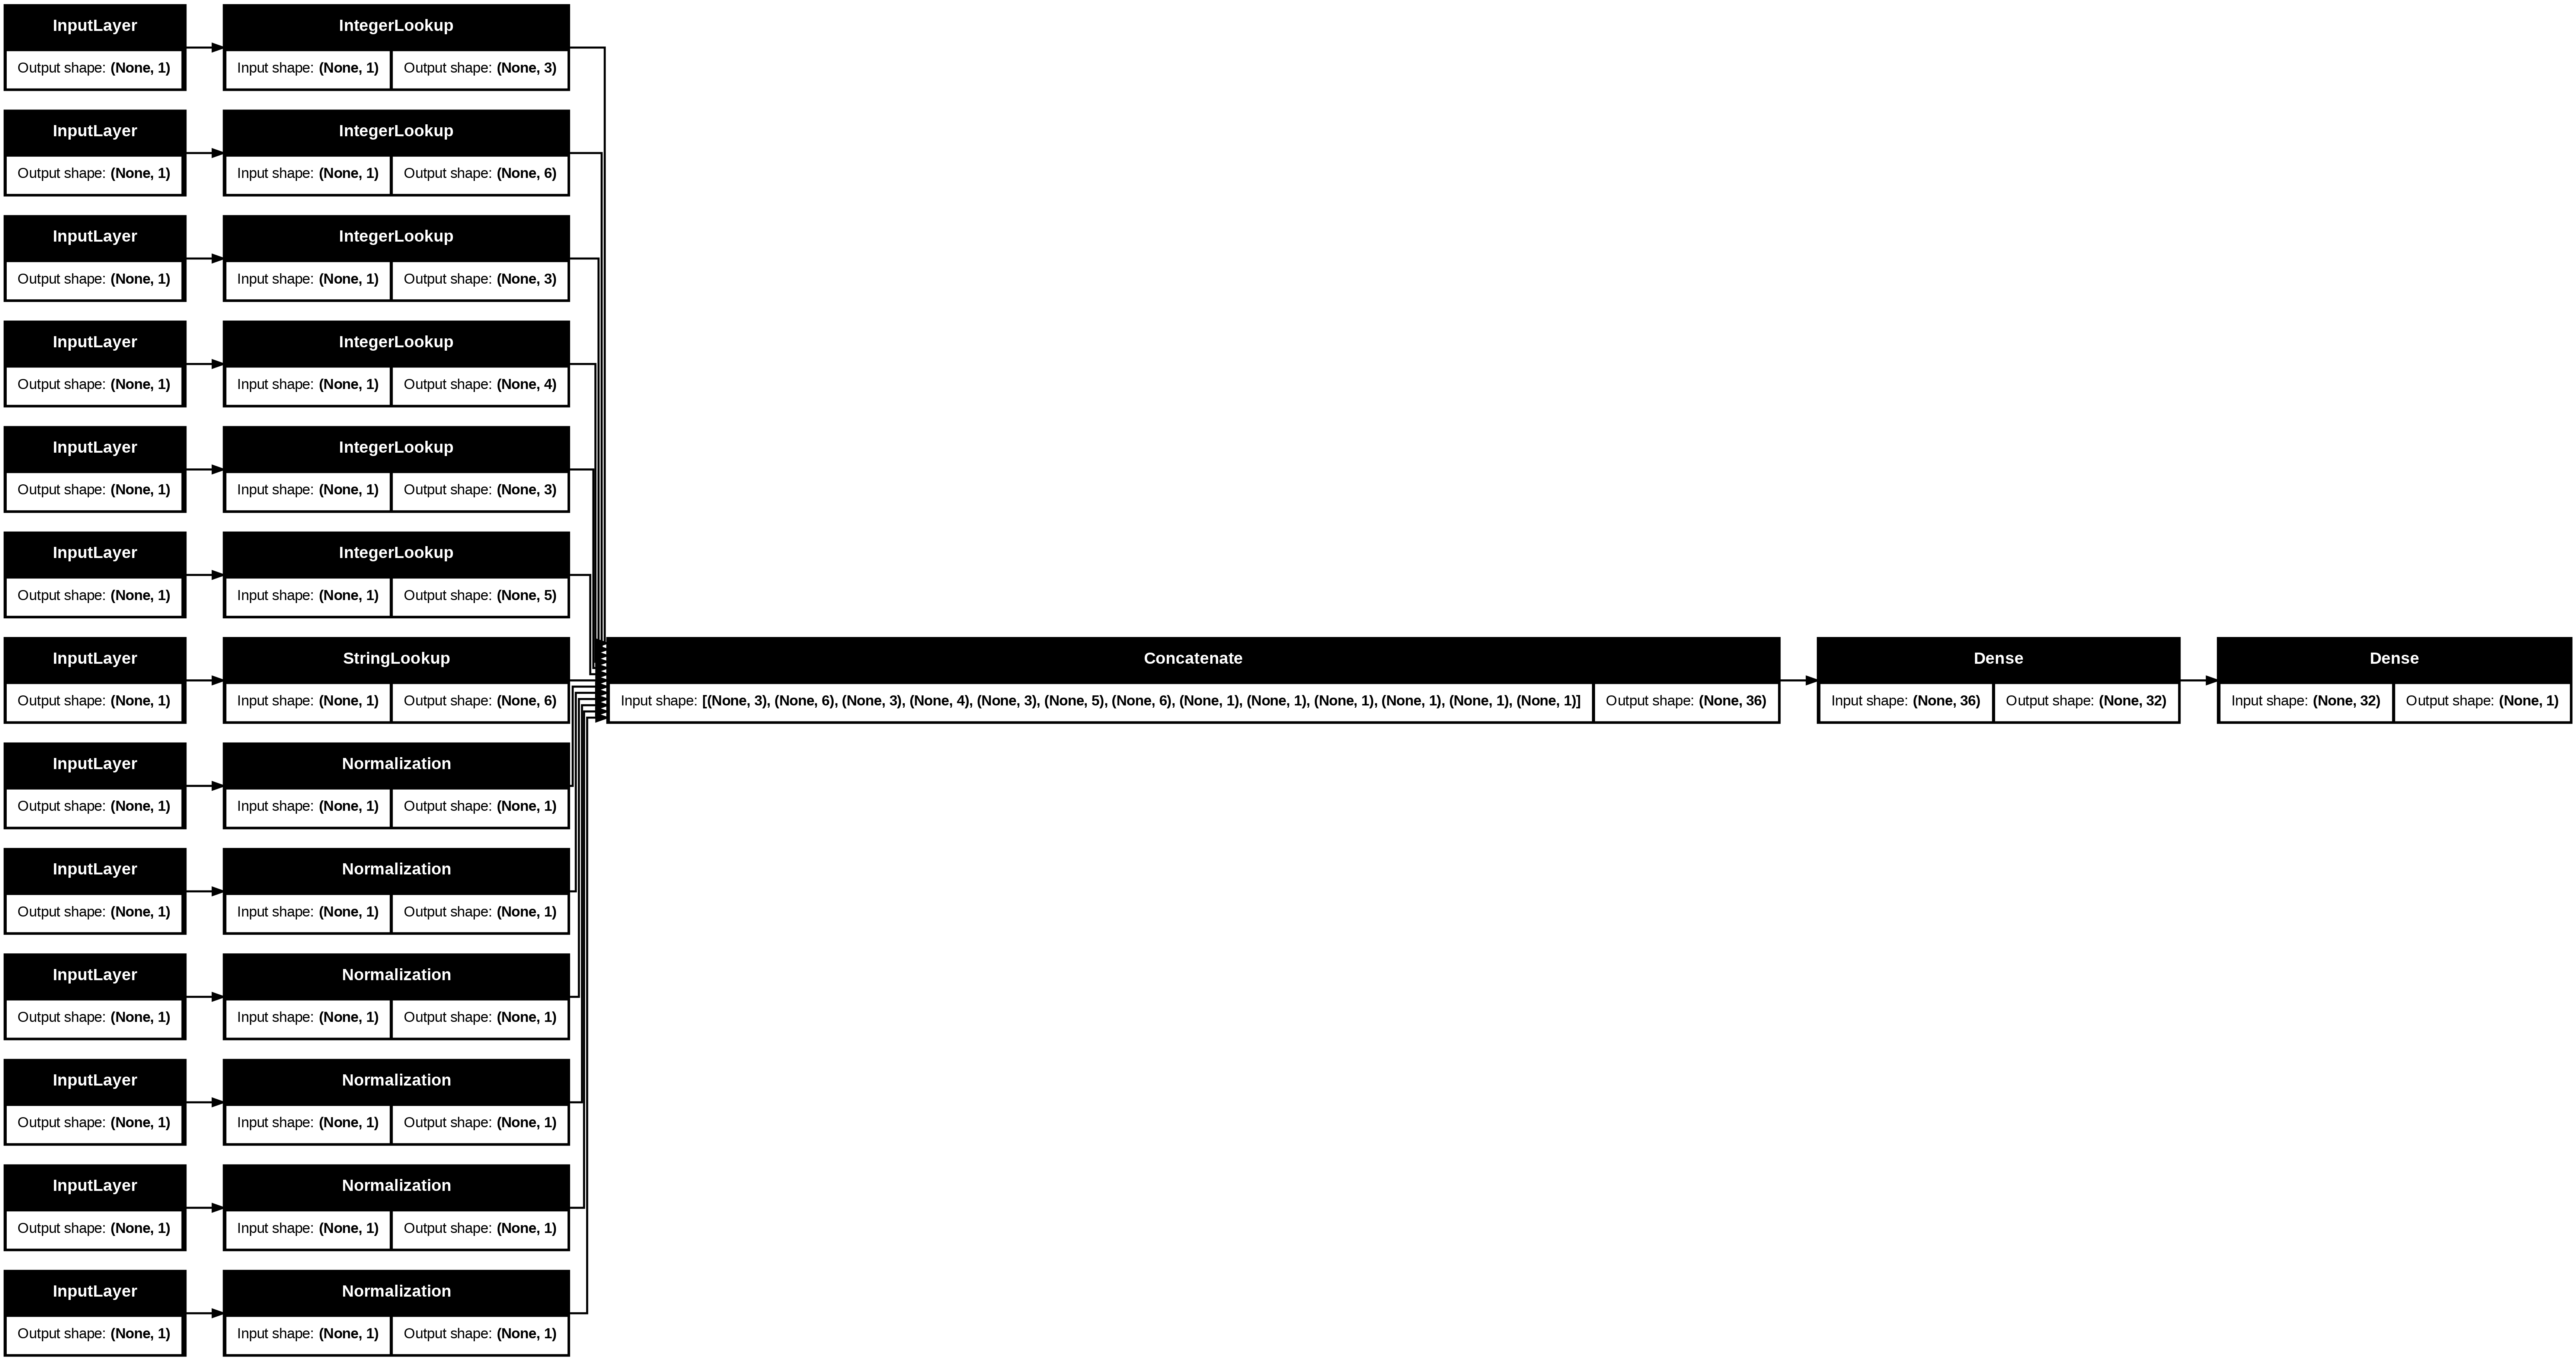

In [44]:
# `rankdir='LR'` is to make the graph horizontal
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Next we compile the model by specifying the optimization technique and loss function to be used in model training. We can also specify the metric(s) that will be logged during training. We will use stochastic gradient descent (`sgd`) for the optimizer and binary cross entropy (log loss) as the loss function. We will log the accuracy metric during training. We can also specify the learning rate hyperparameter here.

In [45]:
learning_rate = 0.01
model.compile(keras.optimizers.SGD(learning_rate=learning_rate), "binary_crossentropy", metrics=["accuracy"])

### Train the model

Now that we've constructed and compiled our model, we can train the model using our training dataset. This is done in keras using the `fit()` function, which also gives us an option to provide the validation dataset which will be used to evaluate validation accuracy after every epoch.

In [46]:
model_result = model.fit(train_ds, epochs=100, validation_data=val_ds)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.5071 - loss: 0.7377 - val_accuracy: 0.4918 - val_loss: 0.7138
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5549 - loss: 0.6906 - val_accuracy: 0.5246 - val_loss: 0.6763
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5719 - loss: 0.6524 - val_accuracy: 0.5246 - val_loss: 0.6458
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6056 - loss: 0.6213 - val_accuracy: 0.5902 - val_loss: 0.6208
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6508 - loss: 0.5955 - val_accuracy: 0.6230 - val_loss: 0.6000
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6798 - loss: 0.5737 - val_accuracy: 0.6230 - val_loss: 0.5824
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7188 - loss: 0.5553 - val_accuracy: 0.6721 - val_loss: 0.5674
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7423 - loss: 0.5396 - val_accuracy: 0.6721 - val_loss: 0.5544

The `fit()` function returns a history attribute that gives the metrics recorded during training as a dictionary. We can print the dictionary keys to see which metrics were stored:

In [47]:
model_result.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Create a figure with two subplots. The first subplot should plot the training and validation loss (`loss` and `val_loss`) and the second subplot should plot the training and validation accuracy (`accuracy` and `val_accuracy`). Make sure you include the axis labels and a legend in each plot.

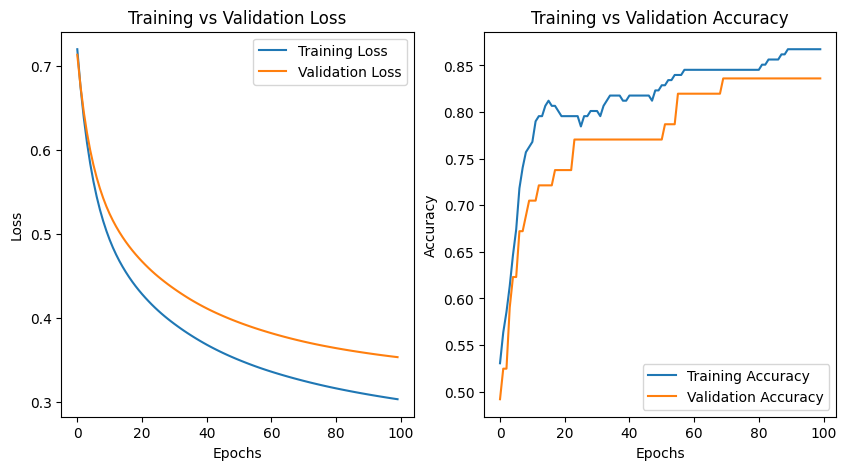

In [48]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

# YOUR CODE HERE
history = model_result.history

ax1.plot(history["loss"], label="Training Loss")
ax1.plot(history["val_loss"], label="Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training vs Validation Loss")
ax1.legend()


ax2.plot(history["accuracy"], label="Training Accuracy")
ax2.plot(history["val_accuracy"], label="Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training vs Validation Accuracy")
ax2.legend()


plt.show()

### Test the model

Finally, we evaluate our trained model on the held-out test set. First we predict the outputs for the test data.

In [49]:
preds = model.predict(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


The model output from the final sigmoid layer is a value between 0 and 1 representing the likelihood that a given sample patient has heart disease. To get the predicted classes, we predict 1 if the output was >= 0.5 and 0 otherwise.

In [50]:
pred_classes = [1 if p >= 0.5 else 0 for p in preds]

Compute and print the test accuracy.

In [51]:
from sklearn.metrics import accuracy_score

# YOUR CODE HERE


y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)


test_accuracy = accuracy_score(y_true, pred_classes)


print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8525


**Question 1: There is a large difference between the training and validation accuracies and the test accuracy. What do you think could explain this difference?**

**Answer:**


The model achieved 86.2% training accuracy, 83.61% validation accuracy, and 85.25% test accuracy, showing a slight overfitting trend. The key reasons for this difference include:

* Overfitting to Training Data – The model learns patterns specific to training but generalizes slightly worse to unseen data.

* Small Dataset & Variability in Splits – With only 303 samples, slight differences in training/validation/test distributions can impact accuracy.

* SGD Optimizer Limitations – A fixed learning rate (0.01) may not be optimal, and adaptive optimizers (Adam, RMSprop) could improve generalization.

* Potential Class Imbalance – The training set has 48 heart disease vs. 133 no-disease cases, which may bias predictions.

## Hyperparameter tuning with K-fold Cross Validation

### k-fold Cross validation

We will use 5-fold cross validation to train and evaluate our classifier. We will not do any model selection/hyperparameter tuning in this step, so we need to split our data into a training and test set.

To split the data into 3 folds we will shuffle the rows and then split them into $k$ equal groups.

In [52]:
k = 3

# Note: np.split raises error if indices_or_sections is
# an integer and doesn't result in equal size splits
folds = np.split(data.sample(frac=1, random_state=seed), indices_or_sections=k)

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Use a for loop to print the number of samples and number of samples from each class in each fold.

In [53]:
folds[0][folds[0]['target']==0]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
225,58,0,4,130,197,0,0,131,0,0.6,2,0,normal,0
201,43,1,4,115,303,0,0,181,0,1.2,2,0,normal,0
52,53,0,4,130,264,0,2,143,0,0.4,2,0,normal,0
168,54,0,3,108,267,0,2,167,0,0.0,1,0,normal,0
223,39,0,3,138,220,0,0,152,0,0.0,2,0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,59,1,0,164,176,1,0,90,0,1.0,1,2,1,0
288,57,0,4,128,303,0,2,159,0,0.0,1,1,normal,0
156,62,0,4,150,244,0,0,154,1,1.4,2,0,normal,0
297,56,1,4,125,249,1,2,144,1,1.2,2,1,normal,0


In [54]:
# YOUR CODE HERE

for i, fold in enumerate(folds):
    total_samples = len(fold)
    no_disease = (fold["target"] == 0).sum()  # Count of class 0
    heart_disease = (fold["target"] == 1).sum()  # Count of class 1
    print(f"Fold {i+1}:")
    print(f"  Total samples: {total_samples}")
    print(f"  No disease (0): {no_disease}")
    print(f"  Heart disease (1): {heart_disease}\n")


Fold 1:
  Total samples: 101
  No disease (0): 75
  Heart disease (1): 26

Fold 2:
  Total samples: 101
  No disease (0): 74
  Heart disease (1): 27

Fold 3:
  Total samples: 101
  No disease (0): 71
  Heart disease (1): 30



### Train a Neural Network classifier

We will use the Neural Network (NN) implemented in previous section for our classification model. Use cross validation to train and evaluate the model. Set hyperparameters to `h1_units=32` and `h1_activation='relu'`, and tune the hypaerparameter `learning_rate` with candidate values `[0.01, 0.03]`.

Implement a for loop to iterate hyperparameters, and then implement another for loop to iterate through each fold, training a new NN model each iteration with one fold assigned to validation and the remaining folds assigned to training. Compute the validation accuracy for each iteration and append it to the `accuracies` list.

In [55]:
from sklearn.metrics import accuracy_score

def create_model(h1_units, learning_rate, h1_activation):
  all_inputs = [
    keras.Input(shape=(1,), name="sex", dtype="int64"),
    keras.Input(shape=(1,), name="cp", dtype="int64"),
    keras.Input(shape=(1,), name="fbs", dtype="int64"),
    keras.Input(shape=(1,), name="restecg", dtype="int64"),
    keras.Input(shape=(1,), name="exang", dtype="int64"),
    keras.Input(shape=(1,), name="ca", dtype="int64"),
    keras.Input(shape=(1,), name="thal", dtype="string"),
    keras.Input(shape=(1,), name="age"),
    keras.Input(shape=(1,), name="trestbps"),
    keras.Input(shape=(1,), name="chol"),
    keras.Input(shape=(1,), name="thalach"),
    keras.Input(shape=(1,), name="oldpeak"),
    keras.Input(shape=(1,), name="slope"),
  ]
  feature_layer = layers.concatenate(
    [
        encode_categorical_feature(all_inputs[0], "sex", train_ds, False),
        encode_categorical_feature(all_inputs[1], "cp", train_ds, False),
        encode_categorical_feature(all_inputs[2], "fbs", train_ds, False),
        encode_categorical_feature(all_inputs[3], "restecg", train_ds, False),
        encode_categorical_feature(all_inputs[4], "exang", train_ds, False),
        encode_categorical_feature(all_inputs[5], "ca", train_ds, False),
        encode_categorical_feature(all_inputs[6], "thal", train_ds, True),
        normalize(all_inputs[7], "age", train_ds),
        normalize(all_inputs[8], "trestbps", train_ds),
        normalize(all_inputs[9], "chol", train_ds),
        normalize(all_inputs[10], "thalach", train_ds),
        normalize(all_inputs[11], "oldpeak", train_ds),
        normalize(all_inputs[12], "slope", train_ds)
    ]
  )
  h1_layer = layers.Dense(h1_units, activation=h1_activation)(feature_layer)
  output_layer = layers.Dense(1, activation="sigmoid")(h1_layer)
  model = keras.Model(inputs=all_inputs, outputs=output_layer)
  model.compile(keras.optimizers.SGD(learning_rate=learning_rate), "binary_crossentropy", metrics=["accuracy"])
  return model


h1_units=32
learning_rate=[0.01, 0.03]
h1_activation='relu'

accuracies = []

for lr in learning_rate:
  accuracies_per_param = []

  for i in range(len(folds)):
      # assign the folds to training and validation
      train = pd.concat(folds[0:i] + folds[i+1:])
      val = folds[i]
      train_ds_original = dataframe_to_dataset(train)
      val_ds_original = dataframe_to_dataset(val, shuffle=False)

      train_ds = train_ds_original.batch(32)
      val_ds = val_ds_original.batch(val.shape[0])

      model = create_model(h1_units, lr, h1_activation)

      model_result = model.fit(train_ds, epochs=10, validation_data=val_ds)

      # predict test set, the output is a probability, not an integer
      pred_val = model.predict(val_ds)

      # YOUR CODE HERE
      # convert the probability to integer - the class label
# Convert the probability to integer class labels (0 or 1)
      pred_val_classes = [1 if p >= 0.5 else 0 for p in pred_val]

      # Extract true labels from the validation dataset
      y_val_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0)

      # Compute accuracy and append to accuracies_per_param
      val_accuracy = accuracy_score(y_val_true, pred_val_classes)
      accuracies_per_param.append(val_accuracy)
      # append accuracy to accuracies_per_param list


  accuracies.append(accuracies_per_param)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3267 - loss: 0.7866 - val_accuracy: 0.3663 - val_loss: 0.7563
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3715 - loss: 0.7424 - val_accuracy: 0.5149 - val_loss: 0.7140
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5046 - loss: 0.7067 - val_accuracy: 0.6238 - val_loss: 0.6791
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6043 - loss: 0.6771 - val_accuracy: 0.6634 - val_loss: 0.6499
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6524 - loss: 0.6524 - val_accuracy: 0.7129 - val_loss: 0.6252
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6819 - loss: 0.6314 - val_accuracy: 0.7228 - val_loss: 0.6039
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6988 - loss: 0.6133 - val_accuracy: 0.7426 - val_loss: 0.5854
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7171 - loss: 0.5977 - val_accuracy: 0.7525 - val_loss: 0.5692
Epoch 9

**Question 2: How many total combinations of the above hyperparameter choices are there?**

**Answer:**


We have two hyperparameters being tuned:

Learning Rate (learning_rate) → 2 choices: [0.01, 0.03]

K-Fold Cross Validation (k=3) → Each model is trained and evaluated across 3 folds

Since we train a separate model for each combination of learning rate and fold, the total number of combinations is:

Total combinations
=
(
Number of learning rates
)
×
(
Number of folds
)
Total combinations=(Number of learning rates)×(Number of folds)
=
2
×
3
=
6
=2×3=6

Thus, 6 different models are trained in this process.



Print the mean and standard deviation of the accuracy from cross validation for all hyperparams(across all $k$ folds).

In [56]:
print(accuracies)
acc_mean = np.mean(accuracies, axis=1)
acc_std = np.std(accuracies, axis=1)

print(pd.DataFrame.from_dict(
    { "Params": learning_rate,
    "Accucary Mean": acc_mean,
    "Accucary Std ": acc_std,
}) )


[[0.7524752475247525, 0.7524752475247525, 0.7524752475247525], [0.8712871287128713, 0.7722772277227723, 0.7029702970297029]]
   Params  Accucary Mean  Accucary Std 
0    0.01       0.752475   1.110223e-16
1    0.03       0.782178   6.907079e-02


**Question 3: If you increased the number of folds, do you expect the standard deviation of the accuracy across $k$ folds to increase or decrease? Why?**

**Answer:**

If we increase the number of folds (k), the standard deviation of accuracy is expected to decrease.

This happens because of following reasons:
* More folds mean each training set is larger, leading to more stable model performance.
*Smaller test sets reduce variability, making accuracy estimates less sensitive to data splits.
*More averaged results smooth out fluctuations, reducing standard deviation.

Thus, higher k leads to more reliable accuracy estimates with lower variance.
